# Section 6: Training and testing

Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv("cleaned_data_v2.csv") 

display(df)

,PUFC04_SEX,PUFC05_AGE,PUFC06_MSTAT,PUFC07_GRADE,PUFC09_GRADTECH,PUFC11_WORK,PUFC14_PROCC,PUFC17_NATEM,PUFC18_PNWHRS,PUFC19_PHOURS,PUFC23_PCLASS,PUFC41_WQTR,PUFNEWEMPSTAT
0,Male,49,Married/Living Together,High School Graduate,No,Yes,Market-oriented skilled agricultural workers,Permanent Job,8,24,Self Employed,Yes,Employed
1,Female,61,Married/Living Together,High School Graduate,No,Yes,"Agricultural, forestry and fishery laborers",Short-term,4,8,Without Pay (Family owned Business),Yes,Employed
2,Male,19,Single,High School Graduate,No,Yes,"Agricultural, forestry and fishery laborers",Short-term,8,24,Private Establishment,Yes,Employed
3,Male,48,Married/Living Together,High School - Second Year,No,Yes,Market-oriented skilled agricultural workers,Permanent Job,4,20,Self Employed,Yes,Employed
4,Female,41,Married/Living Together,High School Graduate,No,Yes,Cleaners and helpers,Permanent Job,12,72,Private Household,Yes,Employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92236,Male,34,Married/Living Together,No grade completed,No,Yes,"Market-oriented skilled forestry, fishery and ...",Permanent Job,5,30,Self Employed,Yes,Employed
92237,Female,32,Married/Living Together,No grade completed,No,Yes,Market-oriented skilled agricultural workers,Permanent Job,4,28,Self Employed,Yes,Employed
92238,Male,29,Married/Living Together,High School Graduate,No,Yes,Production and specialized services managers,Permanent Job,8,40,Employer,Yes,Employed
92239,Female,29,Married/Living Together,College - Third Year,No,No,Unknown,Unknown,0,0,Unknown,Unknown,Not in the Labor Force


Label Encoding

In [2]:
from sklearn.preprocessing import LabelEncoder


categorical_cols = df.select_dtypes(include=['object']).columns ## filter to object cols

label_encoders = {}

## this encode the columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

## print the mappings 
for col, le in label_encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print()
    print(col)
    for original, encoded in mapping.items():
        print(f"{original} -> {encoded}")


PUFC04_SEX
Female -> 0
Male -> 1

PUFC06_MSTAT
Annulled -> 0
Divorced/Separated -> 1
Married/Living Together -> 2
Single -> 3
Unknown -> 4
Widowed -> 5

PUFC07_GRADE
College - First Year -> 0
College - Fourth Year -> 1
College - Second Year -> 2
College - Third Year -> 3
Elementary Graduate -> 4
Grade 1 -> 5
Grade 2 -> 6
Grade 3 -> 7
Grade 4 -> 8
Grade 5 -> 9
Grade 6 -> 10
High School - First Year -> 11
High School - Second Year -> 12
High School - Third Year -> 13
High School Graduate -> 14
No grade completed -> 15
Post Baccalaureate -> 16
Post Secondary - First Year -> 17
Post Secondary - Second Year -> 18
Preschool -> 19
Unknown -> 20

PUFC09_GRADTECH
No -> 0
Yes -> 1

PUFC11_WORK
No -> 0
Yes -> 1

PUFC14_PROCC
Administrative and commercial managers -> 0
Agricultural, forestry and fishery laborers -> 1
Armed forces occupations, other ranks -> 2
Assemblers -> 3
Building and related trades workers, excluding electricians -> 4
Business and administration associate professionals -> 5
B

Assign Target Value and Features

In [3]:
X = df.drop(columns=["PUFNEWEMPSTAT"]).values
y = df["PUFNEWEMPSTAT"].values

Normalizing Data: Standerdizes the features to have a mean of 0 and a standard deviation of 1, which helps the neural network converge faster

In [4]:
X = (X - X.mean(axis=0)) / X.std(axis=0)


Train-Test Split: Split data into 70% training and 30% testing
- Stratify ensures the proportion of classes remains balanced between training and testing sets
- Random State ensures reproducibility

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

Text(0.5, 1.0, 'Train data')

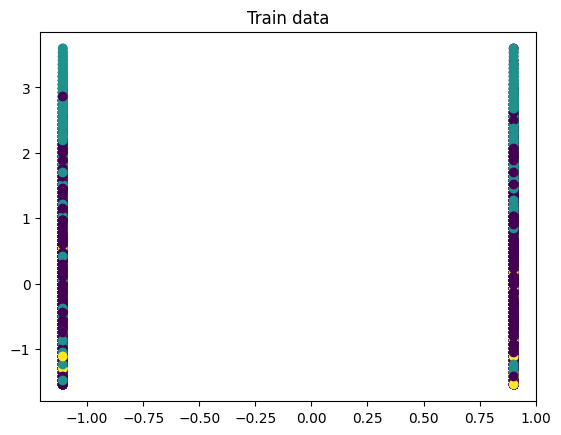

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title('Train data')

Text(0.5, 1.0, 'Test data')

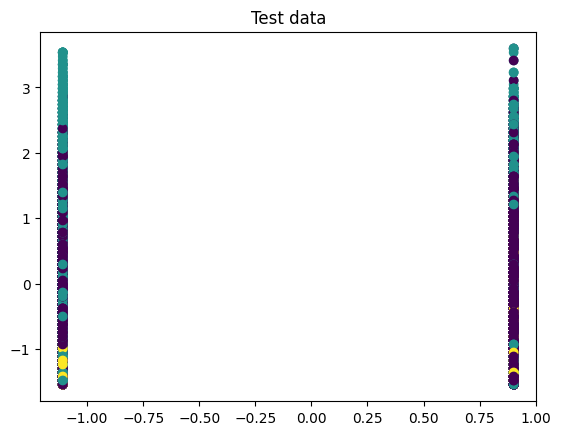

In [7]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test data')

Convert to PyTorch Tensors for PyTorch processing 
- torch.float32 is sued for features, and torch.long is used for classification labels

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
print(X_train.shape)

y_train = torch.tensor(y_train, dtype=torch.long)
print(y_train.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
print(X_test.shape)

y_test = torch.tensor(y_test, dtype=torch.long)
print(y_test.shape)

torch.Size([64568, 12])
torch.Size([64568])
torch.Size([27673, 12])
torch.Size([27673])


Data Loader Class
- DataLoader: Efficiently manages batches for training
- Shuffling : Ensures each epoch has a randomized set of samples to prevent the model from learning the order of data
- Batching : Data is divided into smaller, managable chunks using the specified batch size

In [9]:
import numpy as np

class DataLoader(object):

    def __init__(self, X, y, batch_size):
      
        self.X = X
        self.y = y
        self.batch_size = batch_size

        self.indices = np.array([i for i in range(self.X.shape[0])])
        np.random.seed(1)

    def shuffle(self):
       
        np.random.shuffle(self.indices)

    def get_batch(self, mode='train'):


        X_batch = []
        y_batch = []

    
        if mode == 'train':
            self.shuffle()
        elif mode == 'test':
            self.indices = np.array([i for i in range(self.X.shape[0])])

       
        for i in range(0, len(self.indices), self.batch_size):

           
            if i + self.batch_size <= len(self.indices):
                indices = self.indices[i:i + self.batch_size]

        
            else:
                indices = self.indices[i:]

            X_batch.append(self.X[indices])
            y_batch.append(self.y[indices])

        return X_batch, y_batch

Neural Network Class 
- Input Size: Number of Features (12)
- Number of Classes : Employed, Unemployed, Not in the LAbor Force, Unknown
- Hidden Layers : Customizable with size [64, 32]


Building Layers
- Linear Layers: Each layer has weights and biases
- ReLU Activation: Common in deep learning, applying non-linearity to capture complex patterns


Forward Pass
- Network Pass: Passes input through all layers
- Softmax: Copnverts oputput logits to probabilities, making it suitable for multi-class classficiation


Prediction
- Argmax: Chooses the class with the highest probability

In [10]:
import torch.nn as nn
import torch.nn.init


class NeuralNetwork(nn.Module):

    def __init__(self,
                 input_size,
                 num_classes,
                 list_hidden,
                 activation='relu'):
       
        super(NeuralNetwork, self).__init__()

        self.input_size = input_size
        self.num_classes = num_classes
        self.list_hidden = list_hidden
        self.activation = activation

    def create_network(self):
       
        layers = []

       
        layers.append(nn.Linear(self.input_size, self.list_hidden[0]))  # input to first hidden layer


      
        layers.append(self.get_activation(self.activation))  # Activation function for first layer

        # Iterate over other hidden layers just before the last layer
        for i in range(len(self.list_hidden) - 1):

           
            layers.append(nn.Linear(self.list_hidden[i], self.list_hidden[i + 1]))  # Between hidden layers

          
            layers.append(self.get_activation(self.activation))  # Activation for each hidden layer

        
        layers.append(nn.Linear(self.list_hidden[-1], self.num_classes))  # Last hidden to output
        layers.append(nn.Softmax(dim=1))  # Softmax for classification
        
        self.layers = nn.Sequential(*layers)

    def init_weights(self):
       
        torch.manual_seed(2)

        # For each layer in the network
        for module in self.modules():

            # If it is a torch.nn.Linear layer
            if isinstance(module, nn.Linear):
               
                nn.init.normal_(module.weight, mean=0, std=0.1)

                nn.init.constant_(module.bias, 0)

                

    def get_activation(self,
                       mode='relu'):
        
        activation = nn.Sigmoid()

        if mode == 'tanh':
            activation = nn.Tanh()

        elif mode == 'relu':
            activation = nn.ReLU(inplace=True)

        return activation

    def forward_manual(self,
                       x,
                       verbose=False):
       

        # For each layer in the network
        for i in range(len(self.layers) - 1):

            # If it is a torch.nn.Linear layer
            if isinstance(self.layers[i], nn.Linear):

                x = torch.matmul(x, self.layers[i].weight.T) + self.layers[i].bias

            # If it is another function
            else:
        
                x = self.layers[i](x)

            if verbose:
                # Print the output of the layer
                print('Output of layer ' + str(i))
                print(x, '\n')

        # Apply the softmax function
        probabilities = self.layers[-1](x)

        if verbose:
            print('Output of layer ' + str(len(self.layers) - 1))
            print(probabilities, '\n')

        return x, probabilities

    def forward(self,
                x,
                verbose=False):
        

        # For each layer in the network
        for i in range(len(self.layers) - 1):

            # Call the forward() function of the layer
            # and return the result to x.
            x = self.layers[i](x)

            if verbose:
                # Print the output of the layer
                print('Output of layer ' + str(i))
                print(x, '\n')

        # Apply the softmax function
        probabilities = self.layers[-1](x)

        if verbose:
            print('Output of layer ' + str(len(self.layers) - 1))
            print(probabilities, '\n')

        return x, probabilities

    def predict(self,
                probabilities):
       
        return torch.argmax(probabilities, dim=1)

Model Initialization : Initializes the nueral network with the specified parameters

In [11]:
input_size = 12
number_of_classes = 3
list_hidden = [5, 10]
activation = 'relu'

network = NeuralNetwork(input_size, number_of_classes, list_hidden, activation)


In [12]:
network.create_network()

In [13]:
print(network)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=5, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)


Initializing the model weights

In [14]:
init_weights = network.init_weights()
print(network.layers[0].weight)
print(network.layers[0].bias)

Parameter containing:
tensor([[-0.1041,  0.0917, -0.1304, -0.1110, -0.1219,  0.1168, -0.1057, -0.0119,
         -0.0908,  0.0345, -0.0571, -0.0235],
        [ 0.1008, -0.0753, -0.0225, -0.0433, -0.1507, -0.0459, -0.0848,  0.0527,
          0.0030, -0.0050,  0.1065,  0.0886],
        [ 0.0464, -0.0499,  0.0129,  0.2763,  0.0140,  0.1119,  0.0315,  0.1753,
         -0.0765,  0.1830, -0.0278, -0.0272],
        [-0.1294, -0.0024, -0.0235, -0.0709,  0.1157,  0.0430, -0.1187, -0.0747,
         -0.0902, -0.0015,  0.1386,  0.2579],
        [ 0.1141, -0.0635, -0.1470, -0.0213,  0.1410, -0.0388,  0.0398, -0.1104,
          0.2113, -0.0975,  0.0176, -0.0132]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


Forward Propagation: compute output of each layer

In [15]:
x , probabilities = network.forward(X_train, verbose = True)

Output of layer 0
tensor([[-0.1268,  0.1018,  0.4530, -0.0503,  0.0210],
        [-0.2470, -0.0958,  0.3842, -0.5461, -0.2657],
        [-0.5204, -0.4312,  0.5648,  0.3529,  0.7501],
        ...,
        [-0.4739, -0.1654, -0.0017, -0.8058, -0.7422],
        [-0.2252,  0.1751,  0.4557, -0.1918,  0.0161],
        [ 0.0229, -0.1594,  0.4184, -0.4286,  0.3029]],
       grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[0.0000, 0.1018, 0.4530, 0.0000, 0.0210],
        [0.0000, 0.0000, 0.3842, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5648, 0.3529, 0.7501],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1751, 0.4557, 0.0000, 0.0161],
        [0.0229, 0.0000, 0.4184, 0.0000, 0.3029]], grad_fn=<ReluBackward0>) 

Output of layer 2
tensor([[-0.0419,  0.0374,  0.0893,  ...,  0.0109, -0.0408,  0.0154],
        [-0.0367,  0.0318,  0.0811,  ...,  0.0124, -0.0318,  0.0132],
        [ 0.0052,  0.0222,  0.1585,  ..., -0.0675, -0.1259,  0.0352],
        ...,
   

Loss and Optimizer
- CrossEntropyLoss: Suitable for Classification tasks with multiple classes
- Adam Optimizer: Efficient gradient descent with adaptive learning rates

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
optimizer = optim.Adam(params = network.parameters() , lr = 0.001)

Training the network

In [18]:
data_loader = DataLoader (X_train, y_train , 32)

In [19]:
e = 0
max_epochs = 300
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # TODO: Get the batch for this epoch.
    X_batch, y_batch = data_loader.get_batch()
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)
        
        # TODO: Empty the gradients of the network.
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        scores, probabilities = network.forward(X)
        
        # TODO: Compute the loss
        loss = criterion (scores, y)
        
        # TODO: Backward propagation
        loss.backward()
        
        # TODO: Update parameters
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 0.259171
Epoch: 2 	Loss: 0.138176
Epoch: 3 	Loss: 0.126577
Epoch: 4 	Loss: 0.109205
Epoch: 5 	Loss: 0.099865
Epoch: 6 	Loss: 0.097003
Epoch: 7 	Loss: 0.095792
Epoch: 8 	Loss: 0.095183
Epoch: 9 	Loss: 0.094492
Epoch: 10 	Loss: 0.094364
Epoch: 11 	Loss: 0.094081
Epoch: 12 	Loss: 0.093474
Epoch: 13 	Loss: 0.092960
Epoch: 14 	Loss: 0.092753
Epoch: 15 	Loss: 0.092658
Epoch: 16 	Loss: 0.092517
Epoch: 17 	Loss: 0.092514
Epoch: 18 	Loss: 0.092391
Epoch: 19 	Loss: 0.092468
Epoch: 20 	Loss: 0.092224
Epoch: 21 	Loss: 0.092306
Epoch: 22 	Loss: 0.092204
Epoch: 23 	Loss: 0.092116
Epoch: 24 	Loss: 0.092108
Epoch: 25 	Loss: 0.091900
Epoch: 26 	Loss: 0.091390
Epoch: 27 	Loss: 0.091137
Epoch: 28 	Loss: 0.090942
Epoch: 29 	Loss: 0.090949
Epoch: 30 	Loss: 0.090942
Epoch: 31 	Loss: 0.090847
Epoch: 32 	Loss: 0.090546
Epoch: 33 	Loss: 0.090456
Epoch: 34 	Loss: 0.090588
Epoch: 35 	Loss: 0.090709
Epoch: 36 	Loss: 0.090429
Epoch: 37 	Loss: 0.090593
Epoch: 38 	Loss: 0.090553
Epoch: 39 	Loss: 0.09

Do testing on test data

In [20]:
network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=5, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [21]:
scores, probabilities = network.forward(X_test)
predictions = network.predict(probabilities)
print(predictions)

tensor([0, 1, 0,  ..., 1, 0, 0])


# Section 7: Validation and Error Analysis 

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


num_correct = (predictions == y_test).sum().item()
print("Number of correct instances: ", num_correct)
accuracy = num_correct / len(y_test)
print('Acccuracy: {:.4f}'.format(accuracy))

y_test_np = y_test.numpy()
y_pred_np = predictions.numpy()

print("Classification Report:")
print(classification_report(y_test_np, y_pred_np))

Number of correct instances:  26460
Acccuracy: 0.9562
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20526
           1       0.86      0.95      0.90      5894
           2       0.53      0.26      0.35      1253

    accuracy                           0.96     27673
   macro avg       0.80      0.74      0.75     27673
weighted avg       0.95      0.96      0.95     27673



Based on the classification report, for Class 0 (Employed)

- Precision = 1.00 - Every prediction for "Employed" was correct (no false positives).
- Recall = 1.00 - Every actual "Employed" individual was correctly identified (no false negatives).
- F1-score = 1.00 - Perfect classification for this class.


As for Class 1 (Not in the Labor Force)

- Precision = 0.86 - 86% of the predicted "Not in Labor Force" cases were correct. Some false positives exist.
- Recall = 0.95 - 95% of actual "Not in Labor Force" individuals were correctly identified
- F1-score = 0.90 - Good balance between precision and recall.


While for Class 2 (Unemployed)

- Precision = 0.53 - Only 53% of the predicted "Unemployed" cases were correct (high false positives).
- Recall = 0.26 - Only 26% of actual "Unemployed" people were correctly identified (high false negatives).
- F1-score = 0.35 - Poor balance between precision and recall.


From this classification report, we can conclude that the model struggles the most with Class 2 (Unemployed), as it frequently misclassifies individuals in this category as either "Not in the Labor Force" or "Employed." This indicates that the model has difficulty distinguishing unemployed individuals, likely due to class imbalance features between categories.

In [23]:
conf_matrix = confusion_matrix(y_test.numpy(), predictions.numpy())

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[20523     2     1]
 [    1  5605   288]
 [    0   921   332]]


- Class 0 (Employed) is classified almost perfectly with only 1 mistake (classified as Not in Labor Force).

- Class 1 (Not in Labor Force) is mostly well-classified, but 171 individuals were mistakenly labeled as Unemployed.

- Class 2 (Unemployed) is the most misclassified:

    - 993 unemployed individuals were predicted as "Not in Labor Force" (likely because the model struggles to distinguish between these two groups).

    - Only 260 unemployed cases were correctly classified, which aligns with the low recall (0.21) for Class 2 in the classification report.

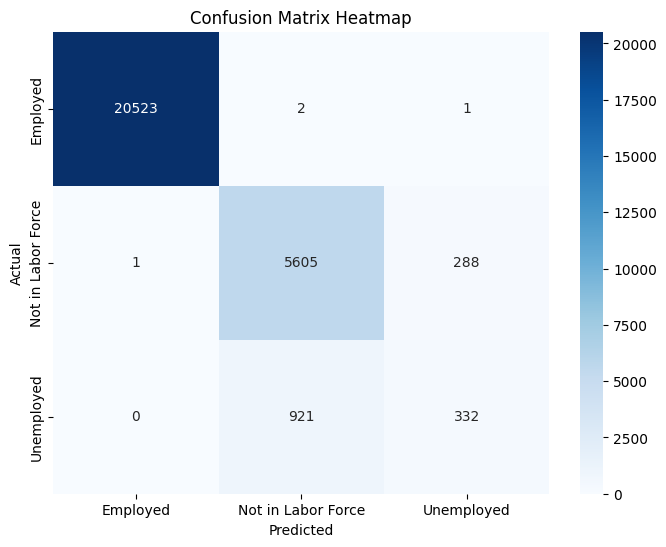

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Employed","Not in Labor Force", "Unemployed"],
            yticklabels=["Employed", "Not in Labor Force", "Unemployed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Section 8: Hyperparameter Tuning 

Importing Libraries
- RandomizedSearchCV: Performs randomized hyperparameter tuning.

- MLPClassifier: Learns from data using backpropagation

In [25]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np


Defining the model
- MPLClassifier: used as feedforward neural network

- random_state=1 ensures reproducibility of results by controlling the random number generation.


Defining Hyperparameter Grid
- hidden_layer_sizes - architecture of the neural network
- activation - specifies the activation function for neurons (relu, tanh, logistice)
- solver: optimization algorithm used for weight updates (adam, sgd)
- alpha: controls the strength of L2 regularization to precent overfitting
- learning_rate: how weights are updated during training (constant, invscaling, adaptive)
- max_iter: sets the max number of training iterations before stopping


In [26]:
# Define model
nn_model = MLPClassifier(random_state=1)

# Define hyperparameter grid
param_dist = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64)], 
    'activation': ['relu', 'tanh', 'logistic'], 
    'solver': ['adam', 'sgd'], 
    'alpha': np.logspace(-4, 0, 10),  
    'learning_rate': ['constant', 'invscaling', 'adaptive'], 
    'max_iter': [200, 500, 1000]  
}

Performing RandomizedSearchCV
- RandomizedSearchCV: Evaluates 10 different combinations of hyperparameters using cross-validation.

- cv=5: Uses 3-fold cross-validation, splitting the training data into 3 subsets. The model trains on 2 subsets and validates on the remaining 1, rotating through all subsets.

- scoring='accuracy': Optimizes the search process based on classification accuracy

- n_jobs=-1: Utilizes all CPU cores to speed up computation.
- random_state=42: Ensures reproducibility by controlling the randomness of the search process.

In [27]:
random_search = RandomizedSearchCV(nn_model, param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=MLPClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00]),
                                        'hidden_layer_sizes': [(32,), (64,),
                                                               (128,), (64, 32),
                                                               (128, 64)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [200, 500, 1000],
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='accuracy')

In [28]:
# Get best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Training Score:", random_search.best_score_)

Best Parameters: {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (64, 32), 'alpha': np.float64(0.002154434690031882), 'activation': 'tanh'}
Best Training Score: 0.9577964167768843


Evaluating for Test Data
- best_estimator_: Extracts the model with the best hyperparameters from RandomizedSearchCV.

- predict(): Generates predictions on the test data.

- accuracy_score(): Computes accuracy by comparing predictions to actual test labels.

In [29]:
# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9580457485635818


Evaluation
- classification_report(): Provides detailed performance metrics including:

- Precision: How many predicted positives were actually positive?

- Recall: How many actual positives were correctly identified?

- F1-Score: Harmonic mean of precision and recall.

- Support: Number of true instances for each class.

In [30]:
# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20526
           1       0.86      0.95      0.91      5894
           2       0.57      0.29      0.39      1253

    accuracy                           0.96     27673
   macro avg       0.81      0.75      0.76     27673
weighted avg       0.95      0.96      0.95     27673

